In [57]:
import numpy as np, scipy, torch
from kymatio.torch import TimeFrequencyScattering1D, Scattering1D
from kymjtfs.utils import generate_am_chirp

f0 = 512
fms = np.logspace(np.log10(4), np.log10(16), 10)
gammas = np.logspace(np.log10(0.5), np.log10(4), 10)
sr = 2**13
duration = 4
N = sr * duration

jtfs = TimeFrequencyScattering1D(
    shape=(N,), T=N, Q=8, J=int(np.log2(N) - 1), J_fr=6, max_pad_factor=1, max_pad_factor_fr=1
).cuda()

In [62]:
import functorch

ModuleNotFoundError: No module named 'functorch'

In [60]:
from tqdm import tqdm

fm_a = torch.tensor(fms[4], requires_grad=True)
gamma_a = torch.tensor(gammas[4], requires_grad=True)
anchor = generate_am_chirp([f0, fm_a, gamma_a], sr=sr, duration=duration)
Sx_anchor = jtfs(anchor.cuda()).detach()
x, y, u, v = [], [], [], []
for fm in tqdm(fms):
    for gamma in tqdm(gammas):
        fm = torch.tensor(fm, requires_grad=True)
        gamma = torch.tensor(gamma, requires_grad=True)
        audio = generate_am_chirp([f0, fm, gamma], sr=sr, duration=duration)
        
        loss = torch.norm(jtfs(audio.cuda()) - Sx_anchor, p=2)
        loss.backward()
        x.append(float(fm))
        y.append(float(gamma))
        u.append(float(- fm.grad))
        v.append(float(- gamma.grad)) # / LOSS

 10%|████████▏                                                                         | 1/10 [00:00<00:03,  2.59it/s]/tmp/ipykernel_37110/1863453174.py:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  fm = torch.tensor(fm, requires_grad=True)

 30%|████████████████████████▌                                                         | 3/10 [00:01<00:02,  2.46it/s]


100%|█████████████████████████████████████████████████████████████████████████████████| 10/10 [00:40<00:00,  4.06s/it]


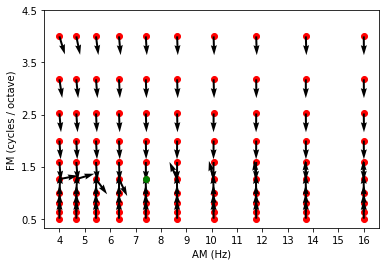

In [61]:
import matplotlib.pyplot as plt
plt.figure()

plt.scatter(x, y, color='r')

u = np.array(u)
v = np.array(v)
grads = np.stack([u, v])
grads = grads / (np.linalg.norm(grads, axis=0) + 1e-8)
plt.quiver(x, y, grads[0, :], grads[1, :])

plt.scatter([fms[4]], [gammas[4]], color='g')

plt.xticks(np.arange(4, fms[-1] + 1))
plt.yticks(np.arange(0.5, gammas[-1] + 1))
plt.xlabel('AM (Hz)')
plt.ylabel('FM (cycles / octave)')
plt.show()

(array([10.,  0.,  8.,  2.,  9.,  1., 10.,  0.,  8., 52.]),
 array([-50.77476914, -45.0492828 , -39.32379646, -33.59831012,
        -27.87282378, -22.14733744, -16.4218511 , -10.69636476,
         -4.97087842,   0.75460792,   6.48009426]),
 <BarContainer object of 10 artists>)

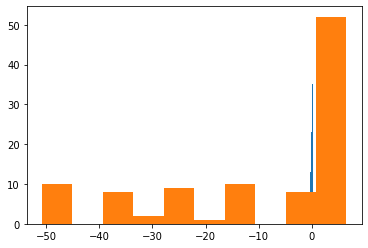

In [21]:
n = 10
F0 = 512
a = torch.linspace(4, 16,  n)
b = torch.linspace(0.5, 4,  n)
AM = a.repeat(10)
FM = b.repeat(n, 1).t().contiguous().view(-1)
AM.requires_grad = True
FM.requires_grad = True

y_am, y_fm = torch.tensor([8.75]), torch.tensor([3.6])
y = generate(512, y_am, y_fm, sr=sr, duration=duration)
x = generate(512, AM[:, None], FM[:, None], sr=sr, duration=duration)
Sx = []
for i in range(n**2):
    Sx.append(jtfs(x[i].cuda()).cpu())
Sx = torch.cat(Sx)
Sy = jtfs(y.cuda()).detach().cpu()
loss = torch.nn.functional.pairwise_distance(Sx[:, :, 0], Sy[:, :, 0])
loss.backward()